In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import types

import data_jat as data


This unreleased version of SpacePy is not supported by the SpacePy team.


In [2]:
d = data.Data('joyce-apj-tab2')
d.read_data()


Found cached data from file eventdata_joyce-apj-tab2_20210420.pickle3.bz2, using contents...


In [3]:
r = list()
l = list()

def weighted_avg(arr, weights, axis=0):
    arr = arr.copy()
    weights = weights.copy()

    nanidx = np.isnan(arr)
    weights[nanidx] = 0
    arr[nanidx] = 0

    total = np.sum(arr * weights, axis=axis)
    count = np.sum(weights, axis=axis)
    
    if len(total.shape) > 0:
        countidx = count == 0
        total[countidx] = np.nan
        count[countidx] = 1
    
    return total / count


for i, event in enumerate(d.eventdata):
    e = types.SimpleNamespace(**copy.deepcopy(event['ChanP']))
    
    lookdir_idx = np.zeros((80), dtype=bool)
    lookdir_idx[20:50] = True
    lookdir_idx[np.array((25, 31, 34, 35, 44))] = False    
    
    fluxbad = np.isnan(e.flux)
    fluxbad = np.min(fluxbad[:, lookdir_idx, :], axis=1)
    fluxbad = np.min(fluxbad, axis=1)
    fluxgood = ~fluxbad

    l.append(np.sum(e.epoch_delta[fluxgood]) * 2)
#     print(e.epoch[-1] + e.epoch_delta[-1] - (e.epoch[0] - e.epoch_delta[0]))
#     print(np.min(e.epoch_delta))

    """
    From Colin:
    
    > -For each energy bin and look direction, do the sum of (flux * delta t)
    > over the entire quiet period, then divide by the total time of the quiet
    > period (including the half delta-t at each end?) Is there any fill in
    > the flux for this? Dividing by the total time if some time bins are fill
    > would tend to decrease the flux (treating fill as zero).

    Correct. I believe at that time, I did treat fills as zeros rather than removing the
    points, which would have been better.
    """
    # weighted average in time
    weights = e.epoch_delta
    # make weights the right dimensionality
    weights = np.tile(weights[:, None, None], (1,) + e.flux.shape[1:])
    for a in ('flux', 'energy_unc_plus', 'energy_unc_minus'):
        setattr(e, a, weighted_avg(getattr(e, a), weights, axis=0))
   
    # make sure the time axis is gone:
    assert(len(e.flux.shape) == 2)
    
    # get only lookdirs of interest and do lookdir average
    for a in ('flux', 'energy_unc_plus', 'energy_unc_minus'):
        setattr(e, a, np.nanmean(getattr(e, a)[lookdir_idx, :], axis=0))
        
    # make sure the lookdir axis is gone:
    assert(len(e.flux.shape) == 1)
    
    ## do energy average
    # weights = e.energy_unc_plus + e.energy_unc_minus
    # flux = weighted_avg(e.flux, weights, axis=0)

    r.append(e.flux * 1e3)  # times 1e3 to go from per keV to per MeV


/home/asher/.miniconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice


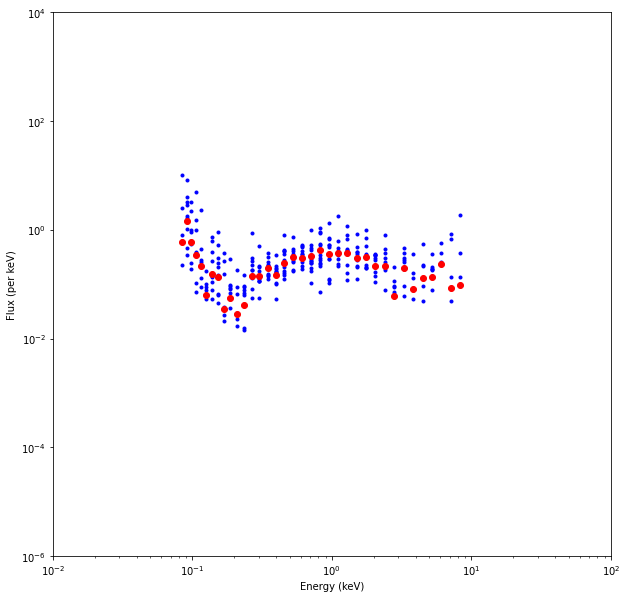

In [4]:
plt.figure(figsize=(10, 10))
plt.xlabel('Energy (keV)')
plt.xscale('log')
plt.xlim(10e-3, 1e2)
plt.ylabel('Flux (per keV)')
plt.yscale('log')
plt.ylim(1e-6, 1e4)

for f in r:
    plt.plot(e.energy[0, 0, :] / 1e3, f, 'b.')  # already scaled by 1e3
    
avg = np.average(np.stack(r, axis=0), weights=np.array(l), axis=0)
plt.plot(e.energy[0, 0, :] / 1e3, avg, 'ro')
